<a href="https://colab.research.google.com/github/pyagoubi/Credit-Default-Prediction/blob/main/Amex_XGBoost_red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
################### Installing RAPIDS on colab

In [ ]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.5 MB/s 


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 300 (delta 74), reused 99 (delta 55), pack-reused 171
Receiving objects: 100% (300/300), 87.58 KiB | 21.90 MiB/s, done.
Resolving deltas: 100% (136/136), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,521 kB]
Hit:13 

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set WD
import os
os.chdir('/content/drive/MyDrive/Amex/parquet')

# XGBoost 
This notebook uses the dataset provided by [@raddar][1]. We use a special XGB dataloader called `DeviceQuantileDMatrix` which uses a small GPU memory footprint. This allows us to engineer more additional columns and train with more rows of data. Our feature engineering is performed using [RAPIDS][2] on the GPU to create new features quickly.
This notebook is built on top of the one from [@Chris Deotte][3], but following changes were made
- Feature Engineering: adding a growth feature (representing percentage change between the first an d last statement of each custumer for specific numeric features)
- Model parameters: New parameters were obtained by hyperparameter tuning with Optuna in a seperate notebook


[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://rapids.ai/
[3]: https://www.kaggle.com/code/cdeotte/xgboost-starter-0-793

# Load Libraries

In [ ]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os

print('RAPIDS version',cudf.__version__)

RAPIDS version 21.12.02


In [ ]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

# Process and Feature Engineer Train Data

In [ ]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
    df.S_2 = cudf.to_datetime( df.S_2 )
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    #df = df.sort_values(['customer_ID','S_2'])
    #df = df.reset_index(drop=True)
    # FILL NAN
    #df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df



In [ ]:
print('Reading train data...')
TRAIN_PATH = 'train.parquet'
train = read_file(path = TRAIN_PATH)

Reading train data...
shape of data: (5531451, 190)


In [ ]:
def handle_na(df,NAN_VALUE):
  df = df.fillna(NAN_VALUE)
  # train[num_cols] = train[num_cols].fillna(NAN_VALUE)
  # for column in cat_cols:
  #   train[column] = train[column].fillna(train[column].mode()[0])
  return df 

In [ ]:
#NA
train = handle_na(train, NAN_VALUE)

In [ ]:
all_cols = [c for c in list(train.columns) if c not in ['customer_ID','S_2']]
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
num_features = [col for col in all_cols if col not in cat_features]

In [ ]:
growth = []  #growth feature

for i in num_features:
  if len(train[train[i]<=0]) == 0: growth.append(i)



In [ ]:
def process_and_feature_engineer(df, cat_features, num_features, growth):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created


    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'max', 'min', 'first', 'last'])
      
    for i in growth:
      test_num_agg[i, 'pctchange'] = (test_num_agg[i]['last']/test_num_agg[i]['first']-1) * 100

    
    test_num_agg['D_54', 'abschange'] = test_num_agg['D_54']['last']-test_num_agg['D_54']['first']
    
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df



In [ ]:
train = process_and_feature_engineer(train,cat_features, num_features, growth)

shape after engineering (458913, 1114)


In [ ]:
features_red = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB Baseline/features_reduced.csv')
features_red = features_red.iloc[:,0]
train = train.loc[:, features_red]

del features_red
_ = gc.collect()

In [ ]:
# ADD TARGETS
targets = cudf.read_csv('train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

There are 598 features!


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

In [ ]:
X = cudf.DataFrame(train.iloc[:,1:-1])
y = cudf.DataFrame(train.iloc[:,-1])
X = X.to_pandas()
y = y.to_pandas()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.25, 
                                                    random_state=SEED,
                                                    stratify=y)

In [ ]:
X_train_base = X_train.copy()
X_test_base = X_test.copy()

# Train the XGB Model

In [ ]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

XGB Version 1.5.0


In [ ]:
#original parameters
# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

In [ ]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
   
# TRAIN MODEL Base

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)

model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_Base.xgb')




[0]	train-logloss:0.66207	valid-logloss:0.66209
[100]	train-logloss:0.23685	valid-logloss:0.23862
[200]	train-logloss:0.22240	valid-logloss:0.22649
[300]	train-logloss:0.21622	valid-logloss:0.22262
[400]	train-logloss:0.21203	valid-logloss:0.22068
[500]	train-logloss:0.20873	valid-logloss:0.21953
[600]	train-logloss:0.20588	valid-logloss:0.21874
[700]	train-logloss:0.20327	valid-logloss:0.21820
[800]	train-logloss:0.20086	valid-logloss:0.21781
[900]	train-logloss:0.19851	valid-logloss:0.21758
[1000]	train-logloss:0.19631	valid-logloss:0.21737
[1100]	train-logloss:0.19415	valid-logloss:0.21725
[1200]	train-logloss:0.19200	valid-logloss:0.21712
[1300]	train-logloss:0.18994	valid-logloss:0.21703
[1400]	train-logloss:0.18799	valid-logloss:0.21703
[1500]	train-logloss:0.18600	valid-logloss:0.21692
[1600]	train-logloss:0.18404	valid-logloss:0.21680
[1700]	train-logloss:0.18220	valid-logloss:0.21679
[1741]	train-logloss:0.18138	valid-logloss:0.21680


In [ ]:
# INFER OOF FOLD K
oof_preds = model.predict(dvalid)
acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)
print('Kaggle Metric =',acc,'\n')

    
del dtrain, dvalid
_ = gc.collect()
    

Kaggle Metric = 0.7922610741219527 



In [ ]:
X_train = X_train_base.copy()
X_test = X_test_base.copy()


gc.collect()



526

In [ ]:
import itertools
features_orig = X_train.loc[:,X_train.columns.str.contains('mean')].columns.to_list()
fpairs = itertools.combinations(features_orig,2)
fpairs = list(fpairs)
chunk = 10
s = len(fpairs)//chunk +1


overview = pd.DataFrame({'chunk':[], 'result':[]})

In [ ]:
#try all multiplication pairs


for i in range(s): 
  if i == s-1:
    pairs = fpairs[i*chunk:]
  else: pairs = fpairs[i*chunk:(i+1)*chunk]

  if i == 0:
    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dvalid = xgb.DMatrix(data=X_test, label=y_test)
    
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
    #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_base.xgb')

    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)
    print(acc)

    overview = overview.append({'chunk': ['base'], 'result': acc}, 
                               ignore_index = True)

    del dtrain, dvalid, model
  
  for m,k in pairs:
    X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
    X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=300) 
  #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  print(acc)

  overview = overview.append({'chunk': i, 'result': acc}, ignore_index = True)

  overview.to_csv(f'/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_{i}.csv',index=False)

  del dtrain, dvalid, model

  X_train = X_train_base.copy()
  X_test = X_test_base.copy()

  _ = gc.collect






In [ ]:
results = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/xgb_mutliply_475.csv')

In [ ]:
results_select = results[results.loc[:,'result']>=0.7910]

In [ ]:
results_select.reset_index(drop= True, inplace = True)

In [ ]:
results_select['chunk'] = results_select['chunk'].astype(str).astype(float)
results_select['chunk'] = results_select['chunk'].astype(int)
results_select

In [ ]:
#create list of features
features_select= []

for index, row in results_select.iterrows():
  i = row['chunk'].astype(int)
  f_temp = fpairs[i*10:(i+1)*10]
  features_select += f_temp




In [ ]:
with open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'w') as csvfile: 
    # creating a csv writer object 
    writer = csv.writer(csvfile) 

    header = ['feature', 'F1', 'F2', 'result', 'keep']    
    writer.writerow(header) 

def write_results(res):
  f = open('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv', 'a', newline = '')
  writer = csv.writer(f)
  writer.writerow(res)
  f.close()





In [ ]:
X_train = X_train_base.copy()
X_test = X_test_base.copy()


gc.collect()

1217

In [ ]:
import csv

thresh = 0.7922
results = pd.DataFrame({'feature':[], 'result':[]})
acc_hist = []



for i, (m,k) in enumerate(features_select):
  X_train[f'{m}_{k}'] = X_train[m]*X_train[k]
  X_test[f'{m}_{k}'] = X_test[m]*X_train[k]


  dtrain = xgb.DMatrix(data=X_train, label=y_train)
  dvalid = xgb.DMatrix(data=X_test, label=y_test)

  model = xgb.train(xgb_parms, 
                      dtrain=dtrain,
                      evals=[(dtrain,'train'),(dvalid,'valid')],
                      num_boost_round=9999,
                      early_stopping_rounds=100,
                      verbose_eval=300) 
          #model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_{i}.xgb')

  oof_preds = model.predict(dvalid)
  acc = amex_metric_mod(y_test.iloc[:,0].values, oof_preds)

  if i > 0: print('Rund no:',i, 'Metric :' ,acc, 'Max:' , max(max(acc_hist), acc))
  else: print('Rund no: ',i, 'Metric : ' ,acc)

  results = results.append({'feature': f'{m}_{k}', 'result': acc}, ignore_index = True)

  del dtrain, dvalid, model
  _ = gc.collect


  if i ==0: 
    if acc <= thresh:
      X_train = X_train_base.copy()
      X_test = X_test_base.copy()
      keep = 'no'
    else: keep = 'yes'
  elif i != 0:
    if acc <= max(acc_hist):
      X_train = X_train.drop([f'{m}_{k}'], axis =1)
      X_test = X_test.drop([f'{m}_{k}'], axis =1)
      keep = 'no'
    else: keep = 'yes'

  acc_hist.append(acc)
  res = [f'{m}_{k}',m,k, acc, keep ]

  write_results(res)

  del keep, res



      


[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22258
[600]	train-logloss:0.20580	valid-logloss:0.21884
[900]	train-logloss:0.19848	valid-logloss:0.21766
[1200]	train-logloss:0.19204	valid-logloss:0.21716
[1500]	train-logloss:0.18597	valid-logloss:0.21690
[1640]	train-logloss:0.18326	valid-logloss:0.21689
Rund no:  0 Metric :  0.792098599084659
[0]	train-logloss:0.66280	valid-logloss:0.66278
[300]	train-logloss:0.21617	valid-logloss:0.22252
[600]	train-logloss:0.20577	valid-logloss:0.21870
[900]	train-logloss:0.19844	valid-logloss:0.21757
[1200]	train-logloss:0.19192	valid-logloss:0.21695
[1500]	train-logloss:0.18588	valid-logloss:0.21674
[1800]	train-logloss:0.18015	valid-logloss:0.21658
[1938]	train-logloss:0.17763	valid-logloss:0.21660
Rund no: 1 Metric : 0.7926531408705695 Max: 0.7926531408705695
[0]	train-logloss:0.66207	valid-logloss:0.66209
[300]	train-logloss:0.21622	valid-logloss:0.22291
[600]	train-logloss:0.20586	valid-logloss:0.21

In [ ]:
res_final = pd.read_csv('/content/drive/MyDrive/Amex/parquet/XGB v2/results.csv')

In [ ]:
res_final = res_final[res_final['keep']=='yes']

In [ ]:
res_final

,feature,F1,F2,result,keep
1,S_26_mean_B_14_mean,S_26_mean,B_14_mean,0.792653,yes
2,S_26_mean_B_13_mean,S_26_mean,B_13_mean,0.793230,yes
63,B_26_mean_B_3_mean,B_26_mean,B_3_mean,0.794010,yes
95,R_27_mean_D_48_mean,R_27_mean,D_48_mean,0.795136,yes


In [ ]:
col_added = list(zip(res_final.loc[:,'F1'], res_final.loc[:,'F2']))
col_added

[('S_26_mean', 'B_14_mean'),
 ('S_26_mean', 'B_13_mean'),
 ('B_26_mean', 'B_3_mean'),
 ('R_27_mean', 'D_48_mean')]

In [ ]:
col_ad = []

for m,k in col_added:
  train[f'{m}_{k}']= train[m]*train[k] 
  col_ad = col_ad + [f'{m}_{k}']

NameError: ignored

In [ ]:
col_ad =pd.Index(col_ad)


Index(['S_26_mean_B_14_mean', 'S_26_mean_B_13_mean', 'B_26_mean_B_3_mean',
       'R_27_mean_D_48_mean'],
      dtype='object')

In [ ]:
FEATURES = FEATURES.append(col_ad)
FEATURES

In [ ]:
del X_train, X_train_base, X_test, X_test_base, y_train, y_test
_ = gc.collect

In [ ]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [ ]:
importances = []
oof = []
#train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'/content/drive/MyDrive/Amex/parquet/XGB v2/XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

NameError: ignored

In [ ]:
# #train model again with full set

# Xy_train = IterLoadForDMatrix(train, FEATURES, 'target')
# dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
# # TRAIN MODEL
# model = xgb.train(xgb_parms, 
#                 dtrain=dtrain,
#                 evals=[(dtrain,'train'),(dtrain,'train')],
#                 num_boost_round=1200,
#                 early_stopping_rounds=100,
#                 verbose_eval=100
#                 )
# model.save_model(f'XGB_full.xgb')

In [ ]:
# CLEAN RAM
del train
_ = gc.collect()

# Save OOF Preds

In [ ]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

,customer_ID,target,oof_pred
0,20eac26171c3d251c55fc78204e59fab1c15fc2bc96d0c...,1,0.694981
1,aea50fdf9b974ccec95fa177c3225a0f913483b457de6e...,0,0.000489
2,32cd2d41aef737b69089882754395925c96eaee1f4a859...,0,0.002206
3,8daa6d5dc2655a8a437531e6b8b96829113cdfe9bf6cae...,0,0.020012
4,0ceba351a3851202542feb49d7385bcef32f6037fc57c7...,1,0.866356


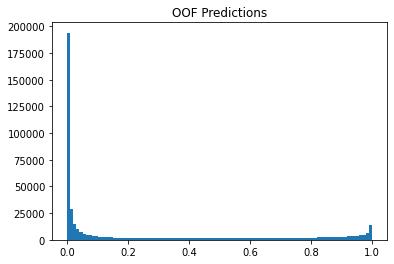

In [ ]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [ ]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [ ]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

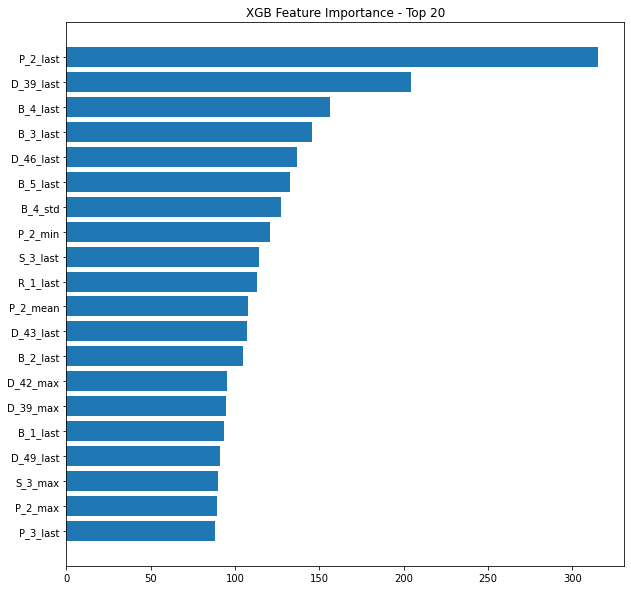

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data


In [ ]:
_ = gc.collect()

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
TEST_PATH = 'test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
test = handle_na(test,NAN_VALUE)
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 2)
We will process test data as 4 separate parts.
There will be 231155 customers in each part (except the last part).
Below are number of rows in each part:
[2841209, 2839857, 2842105, 2840591]


In [ ]:
os.chdir('/content/drive/MyDrive/Amex/parquet/')

# Infer Test

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test,cat_features, num_features, growth)
    for m,k in col_added:
      test[f'{m}_{k}']= test[m]*test[k] 
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    del test 
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    #model.load_model('XGB_full.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{fold}.xgb')
        #model.load_model(f'XGB_full.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (2841209, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (2839857, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (2842105, 190)
shape after engineering (231155, 1114)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (2840591, 190)
shape after engineering (231156, 1114)


# Create Submission CSV

In [ ]:
# WRITE SUBMISSION FILE
#test_preds = np.concatenate(test_preds).to_numpy()
test = pd.DataFrame(index=customers,data={'prediction':[test_preds]})
sub = pd.read_csv('/content/drive/MyDrive/Amex/parquet/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test['prediction'], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

TypeError: ignored

In [ ]:
sub.to_csv(f'/content/drive/My Drive/Amex/parquet/XGB Baseline/submission.csv',index=False)

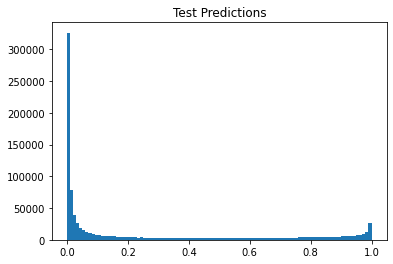

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()

Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=100,
                                                    stratify=y)